In [ ]:
!pip install gdown

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os

sns.set(style="whitegrid")


In [ ]:
tr = pd.read_csv("trader_data.csv", low_memory=False)
sent = pd.read_csv("sentiment.csv")


In [ ]:
!gdown --id 1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs -O trader_data.csv
!gdown --id 1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf -O sentiment.csv

tr = pd.read_csv("trader_data.csv")
sent = pd.read_csv("sentiment.csv")


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/trader_data.csv
100% 47.5M/47.5M [00:00<00:00, 64.1MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/sentiment.csv
100% 90.8k/90.8k [00:00<00:00, 15.1MB/s]


In [ ]:
tr['Timestamp IST'] = pd.to_datetime(tr['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
tr['date'] = tr['Timestamp IST'].dt.date


In [ ]:
sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date


In [ ]:
daily = tr.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum'
}).reset_index()

daily.rename(columns={
    'Closed PnL': 'closedPnL',
    'Size USD': 'volume'
}, inplace=True)


In [ ]:
df = daily.merge(sent[['date','classification','value']], on='date', how='left')


In [ ]:
df['leverage'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())
df['leverage_delta'] = df['leverage'].diff().fillna(0)
df = df.fillna(0)


In [ ]:
acc = tr.groupby('Account').agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
    'Side': 'count'
}).reset_index()

acc.rename(columns={
    'Closed PnL':'avgPnL',
    'Size USD':'avgVolume',
    'Side':'tradeCount'
}, inplace=True)


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(acc[['avgPnL','avgVolume','tradeCount']])

kmeans = KMeans(n_clusters=4, random_state=42)
acc['persona'] = kmeans.fit_predict(X_scaled)


In [ ]:
tr = tr.merge(acc[['Account','persona']], on='Account', how='left')


In [ ]:
persona_daily = tr.groupby(['date','persona']).agg({
    'Closed PnL':'sum',
    'Size USD':'sum'
}).reset_index()

persona_daily.rename(columns={
    'Closed PnL':'dailyPnL',
    'Size USD':'dailyVolume'
}, inplace=True)


In [ ]:
persona_daily = persona_daily.merge(sent[['date','classification','value']], on='date', how='left')


In [ ]:
alpha = persona_daily.copy()

alpha['fear_day'] = alpha['classification']=='Fear'
alpha['greed_day'] = alpha['classification']=='Greed'
alpha['high_volume'] = alpha['dailyVolume'] > alpha['dailyVolume'].mean()
alpha['high_pnl'] = alpha['dailyPnL'] > alpha['dailyPnL'].mean()

alpha['alpha_pocket'] = (
    (alpha['fear_day'] & alpha['high_pnl']) |
    (alpha['fear_day'] & alpha['high_volume']) |
    (alpha['greed_day'] & ~alpha['high_volume']) |
    (alpha['greed_day'] & ~alpha['high_pnl'])
)


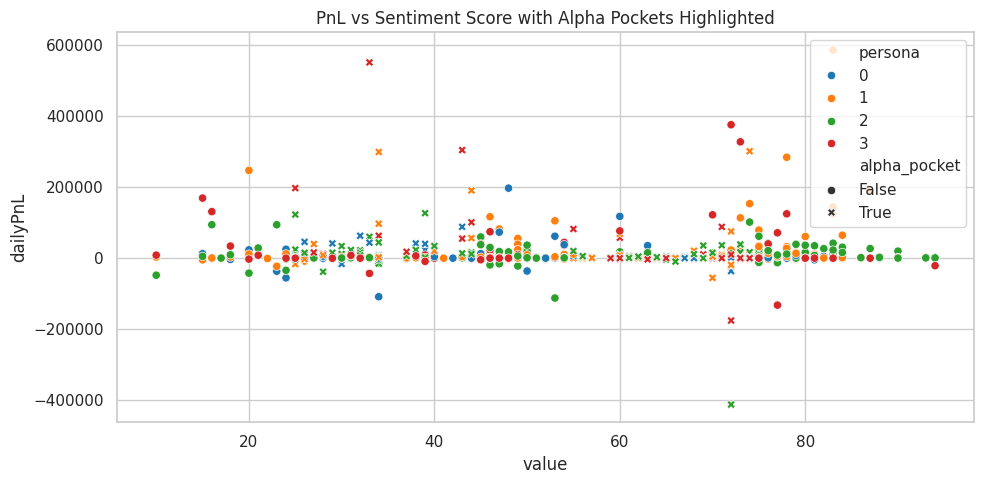

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=alpha, x='value', y='dailyPnL',
                hue='persona', style='alpha_pocket', palette='tab10')
plt.title("PnL vs Sentiment Score with Alpha Pockets Highlighted")
plt.tight_layout()
plt.show()




In [ ]:
import os
os.makedirs('outputs', exist_ok=True)


In [ ]:
plt.savefig('outputs/pnl_vs_sentiment_alpha.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
df = df.sort_values('date')
df['pnl_next'] = df['closedPnL'].shift(-1).fillna(0)
df['sentiment_flag'] = df['classification'].map({
    'Fear':0,'Extreme Fear':0,
    'Greed':1,'Extreme Greed':1
}).fillna(0)


In [ ]:
X = df[['leverage','leverage_delta','volume','sentiment_flag']]
y = df['pnl_next']

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X)

print("MSE:", mean_squared_error(y, preds))


MSE: 4967041168.365248


In [68]:
print("tr shape:", tr.shape)
print("sent columns:", sent.columns.tolist())
print("df shape:", df.shape)
print("persona_daily sample:\n", persona_daily.head())
print("alpha sample:\n", alpha.head())

tr shape: (211224, 18)
sent columns: ['timestamp', 'value', 'classification', 'date']
df shape: (480, 9)
persona_daily sample:
          date  persona    dailyPnL  dailyVolume classification  value
0  2023-05-01        2    0.000000       477.00          Greed   63.0
1  2023-12-05        1    0.000000     50005.83  Extreme Greed   75.0
2  2023-12-14        1 -205.434737    113203.35          Greed   72.0
3  2023-12-15        1  -24.632034     10609.95          Greed   70.0
4  2023-12-16        1    0.000000     15348.77          Greed   67.0
alpha sample:
          date  persona    dailyPnL  dailyVolume classification  value  \
0  2023-05-01        2    0.000000       477.00          Greed   63.0   
1  2023-12-05        1    0.000000     50005.83  Extreme Greed   75.0   
2  2023-12-14        1 -205.434737    113203.35          Greed   72.0   
3  2023-12-15        1  -24.632034     10609.95          Greed   70.0   
4  2023-12-16        1    0.000000     15348.77          Greed   67.0   